# Predicting Conditional Reasoning Responses

In [51]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns

np.random.seed(42)

# Read in experimental data
patterns = pd.read_csv('../conditional_data/oberauer_81_patterns.csv')
patterns = patterns.drop(patterns.columns[0], axis=1)

# Transform counts into individual responses
data = []
for pattern in patterns.columns:
    frequency = patterns.loc[0, pattern]
    data += [[int(pattern[i]) for i in range(len(pattern))]] * frequency
data = pd.DataFrame(np.array(data), columns=['MP', 'MT', 'AC', 'DA'])

### Empirical distribution as a baseline

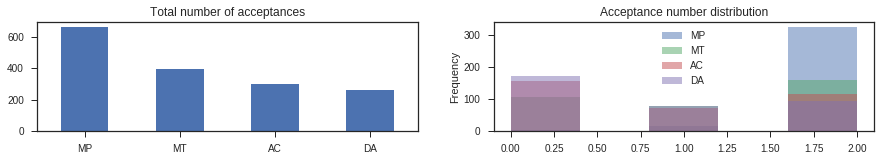

In [159]:
# Plot data summaries
fig, ax = plt.subplots(1, 2, figsize=(15,2))
data.sum(axis=0).plot(kind='bar', rot=0, ax=ax[0], title='Total number of acceptances')
data.plot(kind='hist', bins=5, alpha=0.5, ax=ax[1], title='Acceptance number distribution')
plt.show()

We can use these distributions as a baseline for prediction. 
We simply use the empirical frequency as a forecast, i.e. 

$p_{pred}(MP) = f_{em}(MP)$

To evaluate this, we need a prediction metric, i.e. a scoring function for the prediction p and the truth t

$ (p, t) \rightarrow {\rm I\!R}$

There are several available, for example the quadratic scoring function:

$S_{quad} = \frac{1}{N} \sum_i (Prediction_i - Truth_i)^2$

We define a handful of scores:

In [258]:
def quad_score(prediction, truth):
    '''
    Takes a matrix of predictions and actual outcomes.
    Returns the qudratic Brier-score.
    Proper scoring rule.
    '''
    # The score is the sum of squared deviations
    score = np.sum((truth - prediction)**2)
    # Divided by the number of forecasts for normalization
    score /= truth.shape[0]
    return score


def accuracy(prediction, truth):
    '''
    Takes a matrix of predictions and actual outcomes.
    Returns the accuracy at rank 1.
    Improper scoring rule.
    '''

    matrix = prediction.copy()
    # Only maximum value predictions are considered
    for row in range(0, truth.shape[0]):
        mask = abs(prediction[row] - np.max(prediction[row])) < 0.001
        # If multiple entries have first rank, one is chosen uniformely.
        # This is equivalent to giving a score of 1/N
        matrix[row][mask] = 1 / len(prediction[row][mask])
        # All other predictions are neglected
        matrix[row][np.logical_not(mask)] = 0

    # Only count the predictions of the actual outcomes
    matrix = matrix[np.where(truth > 0.99)]
    score = np.sum(matrix) / len(matrix)
    return score


def one_hot(data):
    ''' 
    Transform data of form [1, 1, 1, 1] to one-hot-encoding form [0, 0, .... 1]
    '''
    indices = (data * np.array([8, 4, 2, 1])).sum(axis=1)
    one_hot_data = np.zeros((len(indices), 16))
    for i in range(len(indices)):
        one_hot_data[i, indices[i]] = 1
    return(one_hot_data)

def log_score(prediction, truth):
    '''
    Takes a matrix of predictions and actual outcomes, returns the logarithmic
    score.
    Proper scoring rule.
    '''


    # Get the matrix elements that came out true
    outcome_predictions = prediction[np.where(truth > 0.99)]
    # The score is the sum of logarithms of the predictions
    score = np.sum(np.log(outcome_predictions))
    return score / truth.shape[0]


def mrr(prediction, truth):
    '''
    Return the Mean Reciprocal Rank score of a matrix of predictions and actual outcomes. Improper scoring rule.
    '''
    import scipy.stats
    # Invert probablities as small numbers are ranked higher
    ranked = 1 / prediction.copy()
    # Rank predictions
    for row in range(ranked.shape[0]):
        # The max rank is given in case of ties
        ranked[row] = scipy.stats.rankdata(ranked[row], method='max')

    truth_mask = np.where(truth > 0.99)
    # The score is 1/maxrank
    ranked_scores = 1 / ranked[truth_mask]
    score = np.sum(ranked_scores)
    return score / truth.shape[0]

In [259]:
# One participant said MP only
mp_only = one_hot(np.array([[1, 0, 0, 0]]))

# One participant said MP only, another MP and MT, another MP, MT, AC, DA
all_modes = one_hot(np.array([[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 1]]))

# Subset of participants who gave consistent answers in both experiments
consistent = one_hot((data[data != 1].dropna().astype(int) // 2).values)

for truth, truth_name in [(mp_only, 'Truth = MP only'), 
                          (all_modes, 'Truth = {MP only, MP&MT, All Modi}'),
                          (consistent, 'Truth = Empirical Data')]:
    print(truth_name)
    print('Prediction\t Brier Logscore Accuracy MRR')
    
    # example predictions
    uniform_prediction = np.array([[1/16] * 16] * len(truth))
    all_only_prediction = np.array([[0] * 15 + [1]] * len(truth))
    empirical_distribution = np.array([consistent.mean(axis=0)]  * len(truth))
    mp_only_prediction = one_hot(np.array([[1, 0, 0, 0]] * len(truth)))
    

    for prediction, prediction_name in ((uniform_prediction, 'Uniform'), 
                                        (all_only_prediction, 'Always ALL'),
                                        (mp_only_prediction, 'Always MP'),
                                        (empirical_distribution, 'Empirical')):
        print('{} \t {:1.2f} \t {:1.1f}  \t {:1.2f} \t {:1.2f}'.format(prediction_name,
                                                   quad_score(prediction, truth), 
                                                   log_score(prediction, truth),                                                   
                                                   accuracy(prediction, truth),
                                                   mrr(prediction, truth)))
    print()

Truth = MP only
Prediction	 Brier Logscore Accuracy MRR
Uniform 	 0.94 	 -2.8  	 0.06 	 0.06
Always ALL 	 2.00 	 -inf  	 0.00 	 0.06
Always MP 	 0.00 	 0.0  	 1.00 	 1.00
Empirical 	 0.71 	 -1.3  	 0.00 	 0.50

Truth = {MP only, MP&MT, All Modi}
Prediction	 Brier Logscore Accuracy MRR
Uniform 	 0.94 	 -2.8  	 0.06 	 0.06
Always ALL 	 1.33 	 -inf  	 0.33 	 0.38
Always MP 	 1.33 	 -inf  	 0.33 	 0.38
Empirical 	 0.68 	 -1.3  	 0.33 	 0.61

Truth = Empirical Data
Prediction	 Brier Logscore Accuracy MRR
Uniform 	 0.94 	 -2.8  	 0.06 	 0.06
Always ALL 	 1.36 	 -inf  	 0.32 	 0.36
Always MP 	 1.45 	 -inf  	 0.27 	 0.32
Empirical 	 0.75 	 -1.6  	 0.32 	 0.57



So we see that 
* the empirical distribution is a decent predictior for it's individuals' responses
* the Accuracy measure is not strictly proper, it gives equal score to different predictions
* Logscore gives infinite scores for 0% predictions

It would be nice if we could enhance the predictive power of the empirical distribution.